## Downloading Data and Installing Dependencies

In [ ]:
!gdown --id "1GbfEJ4JnTGthMs4RP5z17BrCQm6YxtEG"
!unzip LUMS_FALL2020_PROJECT_DATA.zip 
!pip install python_speech_features

Downloading...
From: https://drive.google.com/uc?id=1GbfEJ4JnTGthMs4RP5z17BrCQm6YxtEG
To: /content/LUMS_FALL2020_PROJECT_DATA.zip
802MB [00:13, 59.5MB/s]
Archive:  LUMS_FALL2020_PROJECT_DATA.zip
   creating: Gender_Recognition/Test/
   creating: Gender_Recognition/Test/SPK083_M/
  inflating: Gender_Recognition/Test/SPK083_M/1.wav  
  inflating: Gender_Recognition/Test/SPK083_M/10.wav  
  inflating: Gender_Recognition/Test/SPK083_M/2.wav  
  inflating: Gender_Recognition/Test/SPK083_M/3.wav  
  inflating: Gender_Recognition/Test/SPK083_M/4.wav  
  inflating: Gender_Recognition/Test/SPK083_M/5.wav  
  inflating: Gender_Recognition/Test/SPK083_M/6.wav  
  inflating: Gender_Recognition/Test/SPK083_M/7.wav  
  inflating: Gender_Recognition/Test/SPK083_M/8.wav  
  inflating: Gender_Recognition/Test/SPK083_M/9.wav  
   creating: Gender_Recognition/Test/SPK084_M/
  inflating: Gender_Recognition/Test/SPK084_M/1.wav  
  inflating: Gender_Recognition/Test/SPK084_M/10.wav  
  inflating: Gender_Rec

## Import and Constants

In [ ]:
import glob
from functools import partial

import numpy as np
import pandas as pd
import python_speech_features as mfcc
from matplotlib import pyplot
from scipy.io.wavfile import read
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

tqdm = partial(tqdm, position=0, leave=True)

## Helper Functions
### For Preprocessing

In [ ]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)


def one_hot(Y, labels):
    ''' 
    Function to create one hot encoding of labels. 
    
    Arguments
    ---------
    Y : array
        An array of shape (m, ) containing original labels of the data
    labels : list
        A list of length c containing all unique labels of data in sorted order.
    
    Returns
    -------
    An array of shape (m, c) containing one hot encoded labels.
    '''
    onehot = pd.DataFrame()
    
    for label in labels:
        onehot[label] = list(map(lambda l: int(l == label), Y))
      
    return onehot.values

def load_data(file_names, key):
    '''
    Function to load data from the files.
    
    Arguments
    ---------
    file_names : list
        A list containing names of all the files from where data and labels will be extracted. 
    key : function
        A function to extract label from the filename.
    
    Returns
    -------
    data : array
        Input data of shape (m,n) where m is the no. of instances and n is the no. of features.
    label : array    
        An array of shape (m, ) containing labels of the input data.
    '''
    data, labels = [], []

    for filename in tqdm(file_names):
        sr, audio = read(filename)
        data.append(get_MFCC(audio, sr))
        labels.append(key(filename))

    return np.array(data), np.array(labels)

## For Multinomial Softmax Regression

In [ ]:
def cross_entropy_loss(Hx, Y):
    '''
    Computes cross entropy loss for logistic regression. 
    
    Arguments
    ---------
    Hx : array
        An array containing probabilities computed by applying softmax on dot product of X and thetas. The shape of 
        array is (m, c) where m is the no. of instances and c is the no. of classes. 
    Y : array
        Array of shape (m, c) containing one hot encoded labels.
    
    Returns
    -------
    The calculated value of cross entropy loss over entire dataset.
    '''

    return -1 * (Y * np.log(Hx)).sum() / Y.shape[0]

def softmax(Hx):
    '''
    Calculates the probabilities for every possible class given the hypotheses.  
    
    Arguments
    ---------
    Hx : array
        An array of shape (m, c) where m is the no. of instances and c is the number of classes containing 
        hypotheses calculated for the data.

    Returns
    -------
    An array of shape (m, c) containing probabilities for all possible classes.   
    '''
    exp = np.exp(Hx)
    return exp / exp.sum(axis=1)[:, np.newaxis]


def batch_gradient_descent(X, Y, dev_X, dev_Y, alpha, n_epoch):  
    '''
    Performs gradient descent to learn thetas. Updates thetas by taking n_epoch
    gradient steps with learning rate alpha.
    
    Arguments
    ---------
    X : array
        The input dataset of shape (m, n), where m is the no. of training examples and n is the no. of features.
    Y : array
        Array of shape (m, c), containing one hot encoded labels for training data.
    dev_X : array
        The input validation dataset of shape (m, n), where m is the no. of validation examples and n is the no of features.
    dev_Y : array
        Array of shape (m, c), containing one hot encoded labels for validation data.
    alpha : float
        The learning rate.
    n_epoch : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    thetas : array
        The parameters for the logistic regression function.
    loss : list
        A list for the values of cost on training data after each iteration.
    dev_loss : list
        A list for the values of cost on validation data after each iteration.
    ''' 
    m = len(Y) 
    loss = list()
    dev_loss = list()
    thetas = np.zeros((X.shape[1], Y.shape[1]))
    
    for epoch in range(n_epoch):
        Hx = softmax(X.dot(thetas))
        
        delta = Hx - Y
        gradients = X.transpose().dot(delta) / m
        thetas = thetas - alpha * gradients
        
        loss.append(cross_entropy_loss(Hx, Y))
        dev_loss.append(cross_entropy_loss(softmax(dev_X.dot(thetas)), dev_Y))

    return thetas, loss, dev_loss


def predict(X, thetas, labels):
    '''
    Predicts the labels of the data X using learned weights.
    
    Arguments
    ---------
    X : array
        Input dataset of shape (m, n).
    thetas : array 
        An array of learned weights of shape (n, c) where n is the no of features in data and c is the no of classes.
    labels : list
        A list of length c containing all unique labels of data in sorted order.
    
    Returns
    -------
    A list of length m containing predicted labels of X.
    '''
    prob = softmax(X.dot(thetas))
    indexes = prob.argmax(axis=1)
    return list(map(lambda i: labels[i], indexes))

## **Gender Recognition**

**Reading filenames of train data, validation data and test data using glob().**

In [ ]:
GR_train_files = glob.glob('Gender_Recognition/Train/*/*.wav')
GR_dev_files = glob.glob('Gender_Recognition/Valid/*/*.wav')
GR_test_files = glob.glob('Gender_Recognition/Test/*/*.wav')

**Loading training data, validation data and test data.**

In [ ]:
def gender_label(filename):
    '''
    Function to extract the label of gender data from filename.
    
    Arguments
    ---------
    filename: str
        Name of the input file
    
    Returns
    -------
    Extracted label of either 'F' or 'M'.
    
    '''
    return filename.split('/')[-2][-1]


GR_trainX, GR_trainY = load_data(GR_train_files, gender_label)
GR_devX, GR_devY = load_data(GR_dev_files, gender_label)
GR_testX, GR_testY = load_data(GR_test_files, gender_label)

100%|██████████| 170/170 [00:05<00:00, 30.76it/s]


**Adding bias coulumn to data and applying one hot encoding to labels.**

In [ ]:
GR_LABELS = sorted(np.unique(GR_trainY))

GR_trainX_bias, GR_trainY_oh = np.insert(GR_trainX, 0, 1, axis=1), one_hot(GR_trainY, GR_LABELS)
GR_devX_bias, GR_devY_oh = np.insert(GR_devX, 0, 1, axis=1), one_hot(GR_devY, GR_LABELS)
GR_testX_bias, GR_testY_oh = np.insert(GR_testX, 0, 1, axis=1), one_hot(GR_testY, GR_LABELS)

**Plotting graphs of epochs vs training and validation loss for different values of hyperparameters.**

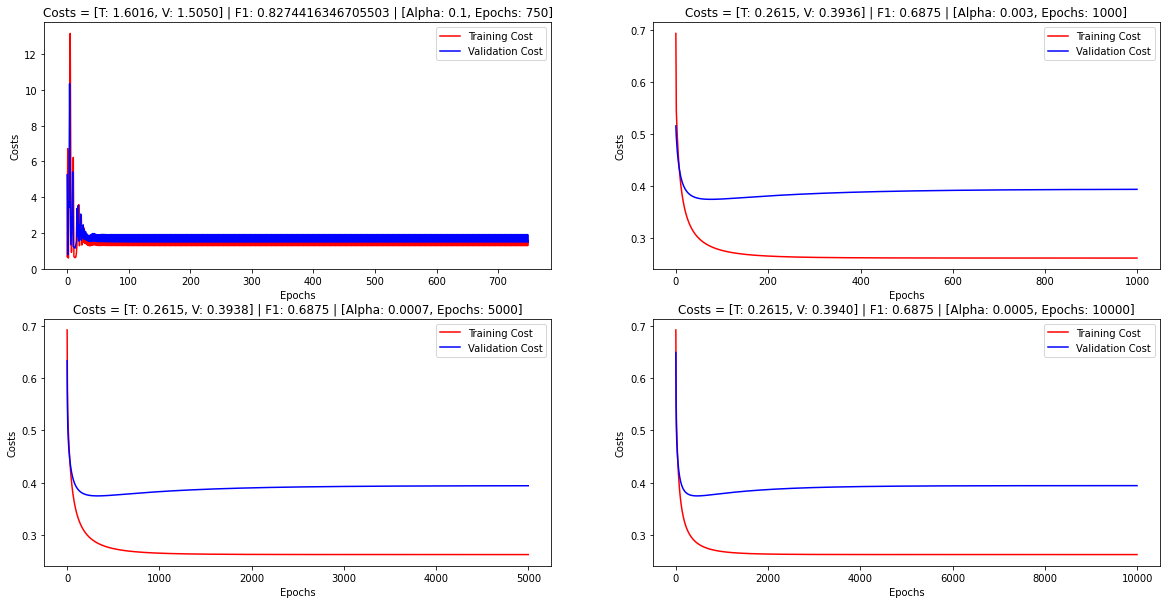

In [ ]:
GR_experiments = [[(0.1, 750), (0.003, 1000)], 
               [(0.0007, 5000), (0.0005, 10000)]]
GR_results = []

fig, axarr = pyplot.subplots(2, len(GR_experiments), figsize=(20, 10))


for j, params in enumerate(GR_experiments):
  for i, (lr, epochs) in enumerate(params):
      # calling batch_gradient_descent function to get values of thetas, training cost and validation cost
      thetas, J, valid_J = batch_gradient_descent(GR_trainX_bias, GR_trainY_oh, GR_devX_bias, GR_devY_oh, lr, epochs)

      # calculating the F! score for each experiment
      dev_predictions = predict(GR_devX_bias, thetas, GR_LABELS)
      F1 = f1_score(GR_devY, dev_predictions, average='macro')

      GR_results.append((J[-1], valid_J[-1], F1, lr, epochs))

      axarr[j, i].plot(J, 'r-', valid_J, 'b-', ms=10)
      axarr[j, i].set_ylabel('Costs')
      axarr[j, i].set_xlabel('Epochs')
      axarr[j, i].legend(['Training Cost', 'Validation Cost'])
      axarr[j, i].set_title("Costs = [T: {:2.4f}, V: {:2.4f}] | F1: {} | [Alpha: {}, Epochs: {}]".format(J[-1], valid_J[-1], F1, lr, epochs))

**Plotting graph for experiment having optimal F1 value on validation data.**

 Cost[T, V]: 1.6016, 1.5050


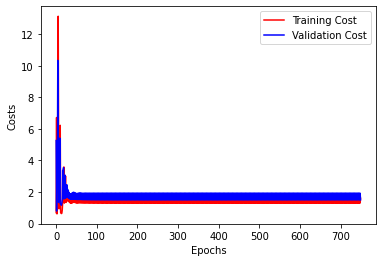

In [ ]:
train_cost, val_cost, F1, lr_opt, epochs_opt = max(GR_results, key=lambda x: x[2])

GR_thetas, GR_J, GR_dev_J = batch_gradient_descent(GR_trainX_bias, GR_trainY_oh, GR_devX_bias, GR_devY_oh, lr_opt, epochs_opt)

print("\033[1m Cost[T, V]: {:2.4f}, {:2.4f}".format(GR_J[-1], GR_dev_J[-1]))
pyplot.plot(GR_J, 'r-', GR_dev_J, 'b-', ms=10)
pyplot.ylabel('Costs')
pyplot.xlabel('Epochs')
pyplot.legend(['Training Cost', 'Validation Cost'])

**Classification report of predictions on test data.**

In [ ]:
GR_predictions = predict(GR_testX_bias, GR_thetas, GR_LABELS)
print(classification_report(GR_testY, GR_predictions, target_names=GR_LABELS))

              precision    recall  f1-score   support

           F       0.62      0.93      0.74        40
           M       0.97      0.82      0.89       130

    accuracy                           0.85       170
   macro avg       0.79      0.87      0.82       170
weighted avg       0.89      0.85      0.86       170



# **Speaker Recognition**

**Reading filenames of train data, validation data and test data using glob().**

In [ ]:
SP_train_files = glob.glob('Speaker_Recognition/Train/*/*.wav')
SP_dev_files = glob.glob('Speaker_Recognition/Valid/*/*.wav')
SP_test_files = glob.glob('Speaker_Recognition/Test/*/*.wav')

**Loading training data, validation data and test data.**

In [ ]:
def speaker_label(filename):
    '''
    Function to extract the label of speaker data from filename.
    
    Arguments
    ---------
    filename: str
        Name of the input file
    
    Returns
    -------
    Extracted label in the range of 001-142
    
    '''
    return filename.split('/')[-2][-5:-2]


SP_trainX, SP_trainY = load_data(SP_train_files, speaker_label)
SP_devX, SP_devY = load_data(SP_dev_files, speaker_label)
SP_testX, SP_testY = load_data(SP_test_files, speaker_label)

100%|██████████| 284/284 [00:10<00:00, 27.79it/s]


**Adding bias coulumn to data and applying one hot encoding to labels.**

In [ ]:
SP_LABELS = sorted(np.unique(SP_trainY))

SP_trainX_bias, SP_trainY_oh = np.insert(SP_trainX, 0, 1, axis=1), one_hot(SP_trainY, SP_LABELS)
SP_devX_bias, SP_devY_oh = np.insert(SP_devX, 0, 1, axis=1), one_hot(SP_devY, SP_LABELS)
SP_testX_bias, SP_testY_oh = np.insert(SP_testX, 0, 1, axis=1), one_hot(SP_testY, SP_LABELS)

**Plotting graphs of epochs vs training and validation loss for different values of hyperparameters.**

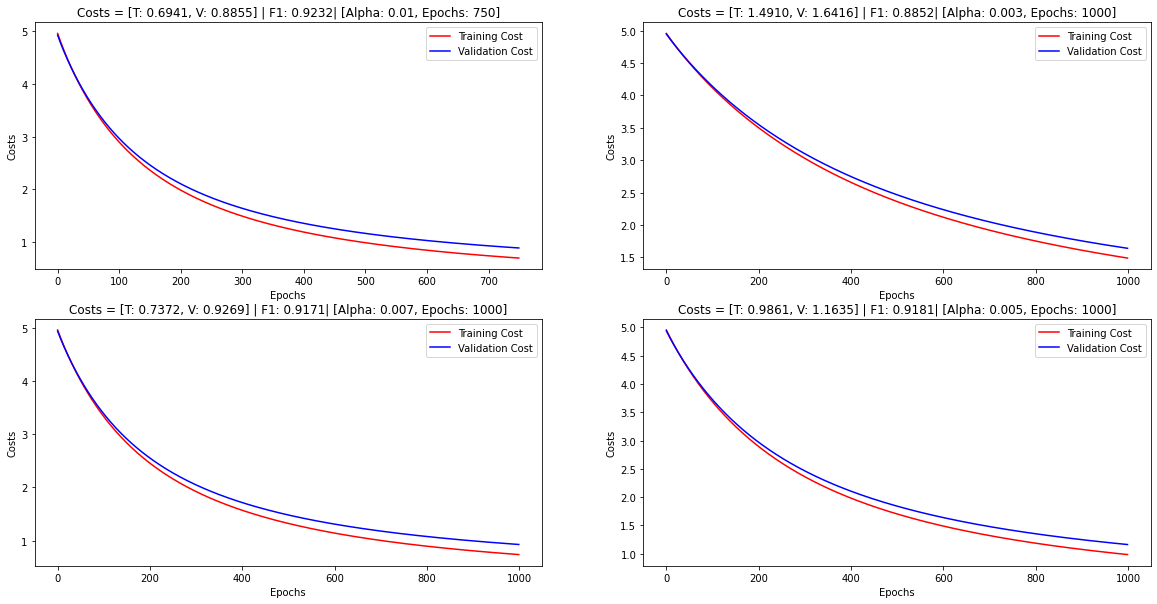

In [ ]:
SP_experiments = [[(0.01, 750), (0.003, 1000)], 
               [(0.007, 1000), (0.005, 1000)]]
SP_results = []

fig, axarr = pyplot.subplots(2, len(SP_experiments), figsize=(20, 10))


for j, params in enumerate(SP_experiments):
  for i, (lr, epochs) in enumerate(params):
      # calling batch_gradient_descent function to get values of thetas, training cost and validation cost
      thetas, J, valid_J = batch_gradient_descent(SP_trainX_bias, SP_trainY_oh, SP_devX_bias, SP_devY_oh, lr, epochs)

      # calculating the F! score for each experiment
      dev_predictions = predict(SP_devX_bias, thetas, SP_LABELS)
      F1 = f1_score(SP_devY, dev_predictions, average='macro')

      SP_results.append((J[-1], valid_J[-1], F1, lr, epochs))

      axarr[j, i].plot(J, 'r-', valid_J, 'b-', ms=10)
      axarr[j, i].set_ylabel('Costs')
      axarr[j, i].set_xlabel('Epochs')
      axarr[j, i].legend(['Training Cost', 'Validation Cost'])
      axarr[j, i].set_title("Costs = [T: {:2.4f}, V: {:2.4f}] | F1: {:2.4f}| [Alpha: {}, Epochs: {}]".format(J[-1], valid_J[-1], F1, lr, epochs))

plotting graph for experiment having optimal F1 value on validation data



 Cost[T, V]: 0.9861, 1.1635


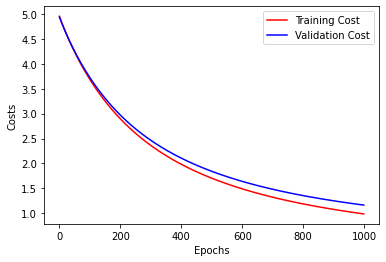

In [ ]:
train_cost, val_cost, F1, lr_opt, epochs_opt = min(SP_results, key=lambda x: x[2])

SP_thetas, SP_J, SP_dev_J = batch_gradient_descent(SP_trainX_bias, SP_trainY_oh, SP_devX_bias, SP_devY_oh, lr, epochs)

print("\033[1m Cost[T, V]: {:2.4f}, {:2.4f}".format(SP_J[-1], SP_dev_J[-1]))
pyplot.plot(SP_J, 'r-', SP_dev_J, 'b-', ms=10)
pyplot.ylabel('Costs')
pyplot.xlabel('Epochs')
pyplot.legend(['Training Cost', 'Validation Cost'])

**Classification report of predictions on test data.**

In [ ]:
SP_predictions = predict(SP_testX_bias, SP_thetas, SP_LABELS)
print(classification_report(SP_testY, SP_predictions, target_names=SP_LABELS))

              precision    recall  f1-score   support

         001       1.00      1.00      1.00         2
         002       1.00      1.00      1.00         2
         003       1.00      1.00      1.00         2
         004       1.00      1.00      1.00         2
         005       1.00      1.00      1.00         2
         006       1.00      1.00      1.00         2
         007       1.00      1.00      1.00         2
         008       1.00      0.50      0.67         2
         009       1.00      1.00      1.00         2
         010       1.00      1.00      1.00         2
         011       1.00      1.00      1.00         2
         012       1.00      1.00      1.00         2
         013       1.00      1.00      1.00         2
         014       1.00      1.00      1.00         2
         015       1.00      1.00      1.00         2
         016       1.00      1.00      1.00         2
         017       0.67      1.00      0.80         2
         018       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
